In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import scipy
import glob
from tqdm import tqdm
from collections import defaultdict
import eye_metrics_utils
import data_utils
import gaze_entropy


import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, RepeatVector, TimeDistributed
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.metrics import mean_squared_error


import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
csv_files = glob.glob("data/*.csv")

In [3]:
csv_files_one = [v for v in csv_files if "One Gaze-Vergence" in v]
csv_files_two = [v for v in csv_files if "Two Gaze-Vergence" in v]
csv_files_three = [v for v in csv_files if "Three Go-Around Gaze-Vergence" in v]

In [4]:
df_par = pd.read_csv("participant.csv")
par_id_arr = [v[-3:] for v in df_par['ID'].tolist()]
flight_exp_arr = df_par['Flight_hour'].tolist()

group_arr = df_par['Group'].astype("str").tolist()

for i,e,g in zip(par_id_arr, flight_exp_arr, group_arr):
    print(i, e, g)
    
print(len(par_id_arr))

032 10 1A
027 18 1A
031 26 1A
028 28 1A
004 35 1A
008 35 1A
010 35 1A
029 40 1A
003 42 1A
007 49 1A
023 50 1A
021 63 2B
006 90 2B
019 98 2B
022 100 2B
015 133 2B
016 200 2B
014 155 2C
005 180 2C
025 200 2C
002 220 2C
001 230 2C
020 230 2C
011 300 2C
017 420 2C
013 23 1A
024 28 1A
018 116 2B
026 150 2C
012 175 2C
009 220 2C
033 1300 2B
32


In [5]:
X = []
y = []

def norm(df_x):
    train_stats = df_x.describe().transpose()
    return (df_x - train_stats['mean']) / train_stats['std']

for csv_files in [csv_files_two]:
#     part = defaultdict(dict)
    for csv in csv_files:
        par_id = csv[14:17]
        
        if par_id not in par_id_arr:
            continue
#         ret = defaultdict(list)
        df_data = pd.read_csv(csv)
        print(csv, len(df_data))
        exp = flight_exp_arr[par_id_arr.index(par_id)]
        group = group_arr[par_id_arr.index(par_id)]
        print(group)
        for df_slice in data_utils.data_slicing(df_data, window_length = 600, stride = 600, min_length=600):
            if (data_utils.check_percentage_null(df_slice) < 0.3): # Ignore data with missing value > 30%
                continue
                
            df_slice.fillna(0.0, inplace=True)
            v = df_slice[['X Pos', 'Y Pos', 'Pupil Diameter']]
            v = norm(v)
            
            X.append(v.values)
#             y.append(exp)
            if "1" in group:
                y.append(0)
            elif "2" in group:
                y.append(1)
            

data\PISSS_ID_001_Approach Two Gaze-Vergence.csv 9554
2C
data\PISSS_ID_002_Approach Two Gaze-Vergence.csv 9430
2C
data\PISSS_ID_003_Approach Two Gaze-Vergence.csv 9368
1A
data\PISSS_ID_004_Approach Two Gaze-Vergence.csv 9862
1A
data\PISSS_ID_005_Approach Two Gaze-Vergence.csv 9245
2C
data\PISSS_ID_006_Approach Two Gaze-Vergence.csv 9739
2B
data\PISSS_ID_007_Approach Two Gaze-Vergence.csv 9677
1A
data\PISSS_ID_008_Approach Two Gaze-Vergence.csv 9923
1A
data\PISSS_ID_009_Approach Two Gaze-Vergence.csv 9243
2C
data\PISSS_ID_010_Approach Two Gaze-Vergence.csv 9923
1A
data\PISSS_ID_011_Approach Two Gaze-Vergence.csv 9492
2C
data\PISSS_ID_012_Approach Two Gaze-Vergence.csv 9431
2C
data\PISSS_ID_013_Approach Two Gaze-Vergence.csv 8691
1A
data\PISSS_ID_014_Approach Two Gaze-Vergence.csv 9307
2C
data\PISSS_ID_015_Approach Two Gaze-Vergence.csv 8812
2B
data\PISSS_ID_016_Approach Two Gaze-Vergence.csv 8259
2B
data\PISSS_ID_017_Approach Two Gaze-Vergence.csv 9184
2C
data\PISSS_ID_018_Approach Two 

In [6]:
print("Training set dimension:" ,np.array(X).shape)


Training set dimension: (457, 600, 3)


In [7]:
sum(y)

266

In [8]:
def sqrt_loss_function(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean((y_true - y_pred)**2))

In [9]:
X = np.array(X)
y = np.array(y)

In [22]:
scaler = StandardScaler()
y_scale = scaler.fit_transform(y.reshape(-1,1))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [12]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(128, input_shape=(900, 3), return_sequences=True, name = "LSTM_1"))
model.add(LSTM(64, name = "LSTM_2"))

model.add(Dense(10, name = "Fully_connected_1"))
model.add(Dense(1, name = "Fully_connected_2"))

model.compile(loss=sqrt_loss_function, optimizer = tf.keras.optimizers.RMSprop(0.001))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_1 (LSTM)                (None, 900, 128)          67584     
_________________________________________________________________
LSTM_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
Fully_connected_1 (Dense)    (None, 10)                650       
_________________________________________________________________
Fully_connected_2 (Dense)    (None, 1)                 11        
Total params: 117,653
Trainable params: 117,653
Non-trainable params: 0
_________________________________________________________________


In [33]:
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(z,3), name="Convolution_1D_1"))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', name="Convolution_1D_2"))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling_1D_1"))
model.add(Flatten(name="Flatten_1"))
model.add(RepeatVector(1, name="Repeat_vector_1"))
model.add(LSTM(128, activation='relu', return_sequences=True, name = "LSTM_1"))
model.add(Dense(10, activation='relu', name = "Fully_connected_1"))
model.add(Dense(1, name = "Fully_connected_2"))

model.compile(loss=sqrt_loss_function, optimizer = tf.keras.optimizers.RMSprop(0.001))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Convolution_1D_1 (Conv1D)    (None, 598, 128)          1280      
_________________________________________________________________
Convolution_1D_2 (Conv1D)    (None, 596, 64)           24640     
_________________________________________________________________
MaxPooling_1D_1 (MaxPooling1 (None, 298, 64)           0         
_________________________________________________________________
Flatten_1 (Flatten)          (None, 19072)             0         
_________________________________________________________________
Repeat_vector_1 (RepeatVecto (None, 1, 19072)          0         
_________________________________________________________________
LSTM_1 (LSTM)                (None, 128)               9830912   
_________________________________________________________________
Fully_connected_1 (Dense)    (None, 10)               

In [13]:
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor='val_loss',
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-3,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1)
]

In [35]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=1, callbacks = callbacks, verbose=1)

Train on 51 samples, validate on 17 samples
Epoch 1/20
51/51 [==============================] - 11s 225ms/step - loss: 0.6593 - accuracy: 0.5490 - val_loss: 0.6231 - val_accuracy: 0.5882
Epoch 2/20
51/51 [==============================] - 11s 208ms/step - loss: 0.7017 - accuracy: 0.6471 - val_loss: 0.6266 - val_accuracy: 0.4706
Epoch 3/20
51/51 [==============================] - 12s 226ms/step - loss: 0.5060 - accuracy: 0.7843 - val_loss: 0.6606 - val_accuracy: 0.5882
Epoch 00003: early stopping


In [36]:
model.evaluate(X_test, y_test)

17/17 [==============================] - 0s 2ms/step


[0.913830041885376, 0.529411792755127]

In [37]:
pred = model.predict(X_test)

In [18]:
p = scaler.inverse_transform(pred)

In [19]:
t = scaler.inverse_transform(y_test)

In [20]:
np.sqrt(mean_squared_error(p.reshape(-1),t))

112.37021542937968

In [38]:
for u,v in zip(p,t):
    print(u,v)

NameError: name 'p' is not defined

In [22]:
len(t)

89

# classification model

In [16]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(128, input_shape=(600, 3), return_sequences=True, name = "LSTM_1"))
model.add(LSTM(64, name = "LSTM_2"))

# model.add(Dense(10, name = "Fully_connected_1"))
model.add(Dense(1, activation="sigmoid", name = "Fully_connected_2"))

model.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_1 (LSTM)                (None, 600, 128)          67584     
_________________________________________________________________
LSTM_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
Fully_connected_2 (Dense)    (None, 1)                 65        
Total params: 117,057
Trainable params: 117,057
Non-trainable params: 0
_________________________________________________________________


In [24]:
model = Sequential()
model.add(Conv1D(filters=200, kernel_size=3, activation='relu', input_shape=(600,3), name="Convolution_1D_1"))
# model.add(Conv1D(filters=128, kernel_size=3, activation='relu', name="Convolution_1D_2"))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling_1D_1"))
model.add(Flatten(name="Flatten_1"))
model.add(RepeatVector(1, name="Repeat_vector_1"))
# model.add(LSTM(128, activation='relu', return_sequences=True, name = "LSTM_1"))
model.add(LSTM(100, activation='relu', name = "LSTM_2"))

# model.add(Dense(100, activation='relu', name = "Fully_connected_1"))
model.add(Dense(100, activation='relu', name = "Fully_connected_2"))

model.add(Dense(1, activation='sigmoid', name = "Fully_connected_3"))

model.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Convolution_1D_1 (Conv1D)    (None, 598, 200)          2000      
_________________________________________________________________
MaxPooling_1D_1 (MaxPooling1 (None, 299, 200)          0         
_________________________________________________________________
Flatten_1 (Flatten)          (None, 59800)             0         
_________________________________________________________________
Repeat_vector_1 (RepeatVecto (None, 1, 59800)          0         
_________________________________________________________________
LSTM_2 (LSTM)                (None, 100)               23960400  
_________________________________________________________________
Fully_connected_2 (Dense)    (None, 100)               10100     
_________________________________________________________________
Fully_connected_3 (Dense)    (None, 1)                

In [25]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=32, callbacks = callbacks, verbose=1)

Train on 273 samples, validate on 92 samples
Epoch 1/20
273/273 [==============================] - 6s 23ms/step - loss: 0.7974 - accuracy: 0.5128 - val_loss: 0.7494 - val_accuracy: 0.5217
Epoch 2/20
273/273 [==============================] - 6s 21ms/step - loss: 0.5758 - accuracy: 0.6960 - val_loss: 0.8628 - val_accuracy: 0.5109
Epoch 3/20
273/273 [==============================] - 6s 20ms/step - loss: 0.4534 - accuracy: 0.7692 - val_loss: 0.8025 - val_accuracy: 0.5978
Epoch 00003: early stopping


In [26]:
prob = model.predict(X_test)

In [1]:
prob

NameError: name 'prob' is not defined

In [27]:
thresh = 0.5

pred = []
for v in prob:
    if v > thresh:
        pred.append(1)
    else:
        pred.append(0)

In [28]:
# prob

In [29]:
for u,v,p in zip(pred,y_test,prob):
    print(u,v,p)

1 1 [0.8817761]
1 0 [0.52432024]
0 1 [0.1819345]
1 1 [0.9212487]
1 1 [0.5834781]
1 0 [0.65762395]
1 1 [0.9602155]
0 1 [0.15185118]
1 1 [0.7170392]
1 0 [0.544924]
1 0 [0.84624684]
1 1 [0.91618407]
1 1 [0.99895716]
1 0 [0.67003673]
1 1 [0.6024354]
1 1 [0.992162]
1 1 [0.9341528]
1 0 [0.5717106]
1 0 [0.8127475]
1 0 [0.610448]
1 1 [0.88520926]
1 0 [0.9267588]
0 1 [0.323517]
1 0 [0.63909256]
1 1 [0.95496136]
1 0 [0.93067265]
1 0 [0.75693667]
1 0 [0.939924]
1 1 [0.9514601]
0 1 [0.32093677]
1 1 [0.6276399]
1 1 [0.9922619]
1 1 [0.99549294]
0 1 [0.16066366]
1 1 [0.758509]
0 0 [0.2493594]
0 1 [0.3883038]
0 0 [0.28719753]
1 1 [0.50960296]
0 0 [0.44962814]
1 1 [0.88308346]
1 0 [0.8301594]
0 1 [0.4572416]
1 1 [0.9371617]
0 1 [0.35862622]
1 1 [0.65691465]
0 1 [0.39484733]
0 1 [0.49835265]
0 1 [0.22887754]
1 0 [0.9508226]
1 0 [0.8132982]
1 1 [0.65852576]
0 0 [0.49839276]
1 1 [0.64068085]
1 0 [0.85552573]
1 0 [0.61888504]
0 0 [0.33016577]
0 1 [0.45093572]
0 1 [0.42382315]
1 0 [0.72483236]
1 1 [0.727485

In [30]:
from sklearn.metrics import classification_report
target_names = ['group 1', 'group 2']
print(classification_report(y_test, pred, target_names=target_names))

              precision    recall  f1-score   support

     group 1       0.32      0.24      0.28        37
     group 2       0.56      0.65      0.61        55

    accuracy                           0.49        92
   macro avg       0.44      0.45      0.44        92
weighted avg       0.47      0.49      0.47        92



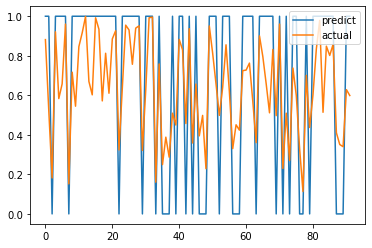

In [32]:

plt.plot(, label="predict")
plt.plot(prob, label="actual")
plt.legend(loc='upper right')
plt.show()